# Validate the model against human labeled data

This notebook performs the following tasks:
- reads in posterior data from BASE-9
- generates features from these data, 
- uses the model created in the previous notebook to classify the posterior sampling as "Good" vs. "Bad"
- compares the model output to human-labeled classes for validation.  

Here we use a model trained on data from NGC 2682 (M67; generated by Justyce Watson) to predict labels for data on NGC 6819 (generated by Elizabeth Jeffery). If you need access to these data, please contact Aaron Geller.

We use functions from the `base9_ml_utils.py` file.  See the comments and markdown in that code for more details.

___
*Authors:* Justyce Watson, Aaron Geller\
*Date:* August 2025


## Import all functions from the `base9_ml_utils.py` file

In [1]:
# import functions from .py file
from base9_ml_utils import *

# The lines below are useful if you plan to make changes to the base9_ml_utils.py file.
# They will allow the notebook to refresh when you save changes to the .py file.
#
# %load_ext autoreload
# %autoreload 2


In [2]:
# import seaborn for the plot at the end
import seaborn as sns

## Use the model to predict labels for NGC 6819 data

The procedure here is the same as in the `apply_model.ipynb` notebook.  See that file for more information.

In [3]:
# directory on your computer where the .res data files are stored
directory = '/Users/justycewatson/Desktop/CIERA_files/NGC6819/ngc6819_single_resfiles' 

# create a DataFrame with features for each star using the 'create_features'
ngc6819_statistic = create_features(directory, file_prefix='gaia_', file_suffix='_sin2')

# Read in the saved model (as a scipy pipeline object)
pipe = load_model('my_model.pkl')

# use the model to label the NGC 6819 data
y_pred_6819 = make_preds(pipe, ngc6819_statistic)

# quick sanity check
print(
f'The model predicts {len(np.where(y_pred_6819 == "Good")[0])} "Good" \
and {len(np.where(y_pred_6819 == "Bad")[0])} "Bad" labels for these data.'
)


The model predicts 366 "Good" and 1322 "Bad" labels for these data.


## Read in Elizabeth's labeled data

Elizabeth used the following rank labels:
- 1 : good sampling (chain converges reasonably)
- 2 : poor sampling (no sampling or highly correlated)
- 3 : parts of chain seem convergent
- 4 : flat distribution 

In [5]:
# Read in Elizabeth's data, label the columns and keep only the necessary data
column_names = ['file', 'source_id', 'rank']
rank_6819 = pd.read_csv( 'data/NGC6819/ngc6819_checkRes_all.txt', sep='\s+', names=column_names, skiprows=1)
rank_6819= rank_6819.drop('file', axis=1)

# display the DataFrame in the notebook
rank_6819

,source_id,rank
0,2076220554197701504,4
1,2076220829075672960,4
2,2076220966514688128,3
3,2076224784750223232,4
4,2076227116907912960,4
...,...,...
1683,2076616859415037824,3
1684,2076617276038017664,4
1685,2076617447828109440,4
1686,2076617477890443008,2


# Merge the DataFrames 

Here we merge the model predictions with Elizabeth's labels using the `source_id` column.

In [6]:
# append the predictions from the model to the features DataFrame (assumes they are in the same order)
ngc6819_statistic['ml_label'] = y_pred_6819
ngc6819_statistic

# ensure that both of the ID columns are of the same type (string)
rank_6819['source_id'] = rank_6819['source_id'].astype('str')
ngc6819_statistic['source_id'] = ngc6819_statistic['source_id'].astype('str')

# merge in Elizabeth's labels
ngc6819_validate = pd.merge(ngc6819_statistic, rank_6819, on='source_id',  how='inner')

# print the result
ngc6819_validate

,source_id,Width,Upper_bound,Lower_bound,Stdev,SnR,Dip_p,Dip_value,KS_value,KS_p,ESS,ml_label,rank
0,2076279137552154112,1.611105,0.281932,0.241271,0.709164,12.619723,0.0,0.015125,0.169402,6.810856e-158,10524.900916,Bad,4
1,2076298933067389056,0.851659,0.281932,0.241271,0.492672,18.154950,0.0,0.075300,0.250364,0.000000e+00,9262.244918,Bad,3
2,2076584355102288128,1.568087,0.281932,0.241271,0.706918,12.674155,0.0,0.015795,0.167530,5.876039e-152,9791.326997,Bad,4
3,2076488525792609792,0.384405,0.281932,0.241271,0.494811,18.364221,0.0,0.052020,0.284000,0.000000e+00,10155.298204,Bad,3
4,2076581851147039232,1.684027,0.281932,0.241271,0.748072,11.787783,0.0,0.021270,0.181619,1.034206e-178,9848.749837,Bad,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1683,2076393834663325568,1.420736,0.281932,0.241271,0.685752,12.768550,0.0,0.009732,0.156574,8.022420e-135,9976.742533,Bad,4
1684,2076380400005524224,1.370467,0.281932,0.241271,0.686048,12.883365,0.0,0.021400,0.139028,1.390574e-104,10068.190019,Bad,4
1685,2076299895139969536,0.444381,0.281932,0.241271,0.175729,54.419198,0.0,0.085369,0.168112,2.967698e-154,10078.694737,Good,2
1686,2076393662864610688,1.519873,0.281932,0.241271,0.696125,12.398271,0.0,0.016644,0.161753,6.511847e-144,10813.460015,Bad,4


## Create a bar chart comparing rank number to the ML predictions

The expectation is that the model will have more "Good" labels for Elizabeth's lower rank numbers (e.g., 1,2) and more "Bad" labels for Elizabeths higher rank numbers (e.g., 3,4).

In [7]:
# Create a new DataFrame to help with plotting the data

# grab only the columns that we need
df_plot = ngc6819_validate[["ml_label", "rank"]]

# count number of occurrences per (rank, label)
df_counts = df_plot.groupby(["rank", "ml_label"]).size().reset_index(name="count")

# display the DataFrame
df_counts

,rank,ml_label,count
0,1,Bad,26
1,1,Good,229
2,2,Bad,82
3,2,Good,115
4,3,Bad,305
5,3,Good,18
6,4,Bad,909
7,4,Good,4


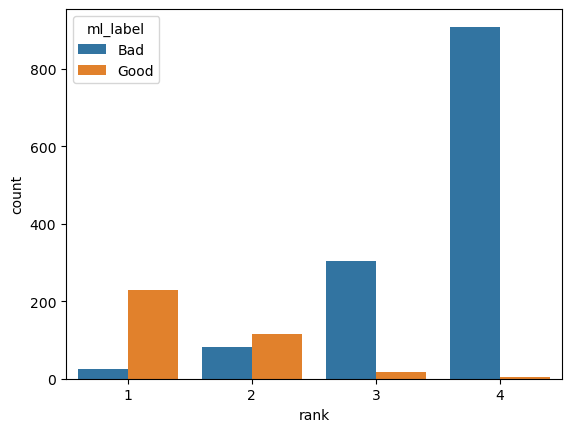

In [8]:
# use Seaborn to create a simple barplot
_ = sns.barplot(data=df_counts, x="rank", y="count", hue="ml_label")